## Recommandation Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [49]:

import pandas as pd
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import networkx as next
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import networkx as nx


### import nutrition Dataset

In [50]:
# 1. Load your data
food_df = pd.read_csv('../../data/RecommandationDatasets/nutrients_csvfile.csv')  
print(food_df.head())

                    Food Measure  Grams Calories Protein Fat Sat.Fat Fiber  \
0             Cows' milk   1 qt.    976      660      32  40      36     0   
1              Milk skim   1 qt.    984      360      36   t       t     0   
2             Buttermilk   1 cup    246      127       9   5       4     0   
3  Evaporated, undiluted   1 cup    252      345      16  20      18     0   
4         Fortified milk  6 cups  1,419    1,373      89  42      23   1.4   

  Carbs        Category  
0    48  Dairy products  
1    52  Dairy products  
2    13  Dairy products  
3    24  Dairy products  
4   119  Dairy products  


In [51]:
food_df.shape

(335, 10)

In [52]:
food_df.isna().sum()

Food        0
Measure     0
Grams       0
Calories    1
Protein     0
Fat         0
Sat.Fat     2
Fiber       0
Carbs       0
Category    0
dtype: int64

In [53]:
food_df.duplicated().sum()

0

In [54]:
food_df.nunique()

Food        329
Measure      61
Grams       103
Calories    152
Protein      40
Fat          45
Sat.Fat      38
Fiber        57
Carbs        80
Category     16
dtype: int64

In [55]:
food_df = food_df.dropna()

#### Import User Nutrition Dataset

In [56]:
user_df = pd.read_csv('../../data/preproccedData/Augmented_PreProccedNutrationParameters.csv')
print(user_df.head())

   Age  Gender      Height     Weight  Carbohydrate_Consumption  \
0   24       1  161.609263  48.731866                  1.852525   
1   24       1  159.653670  53.637920                  0.933021   
2   28       0  148.049594  46.770525                  2.773378   
3   24       0  157.719943  54.580482                  1.856103   
4   22       0  149.030373  44.849854                  1.855097   

   Protein_Intake  Fat_Intake  Regularity_of_Meals  Portion_Control  \
0        1.090620    0.916151             0.959783         1.083803   
1        2.175717    0.904236             0.008224         1.065243   
2        3.266809    0.920246             0.000000         2.150421   
3        1.071392    0.915962             0.960743         3.224980   
4        1.116779    0.916990             0.950166         2.145013   

   Hydration  Caloric_Balance  Sugar_Consumption        BMI  DiabetesRisk  \
0   2.043815      2120.952023           1.061643  17.093053     30.774236   
1   1.038885    

In [57]:
user_df.duplicated().sum()

0

#### Define feature and target columns

In [58]:
feature_cols = ['Age', 'Gender', 'Height', 'Weight', 'Regularity_of_Meals',
                'Portion_Control', 'Hydration', 'Caloric_Balance', 
                'Sugar_Consumption', 'BMI', 'DiabetesRisk', 
                 'NutritionRisk']

target_cols = ['Protein_Intake', 'Fat_Intake', 'Carbohydrate_Consumption','NutritionRisk','DiabetesRisk']

#### Scale features

In [59]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
X = scaler_X.fit_transform(user_df[feature_cols])

scaler_y = StandardScaler()
y = scaler_y.fit_transform(user_df[target_cols])


#### Create graph edges based on Age and BMI similarity

In [60]:
from sklearn.neighbors import NearestNeighbors
import torch
from torch_geometric.data import Data

k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
edges = []
for i, neighbors in enumerate(nbrs.kneighbors(X, return_distance=False)):
    for j in neighbors:
        if i != j:
            edges.append([i, j])
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


#### Build PyG Data object

In [61]:
x = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, y=y)

#### Visualize the graph

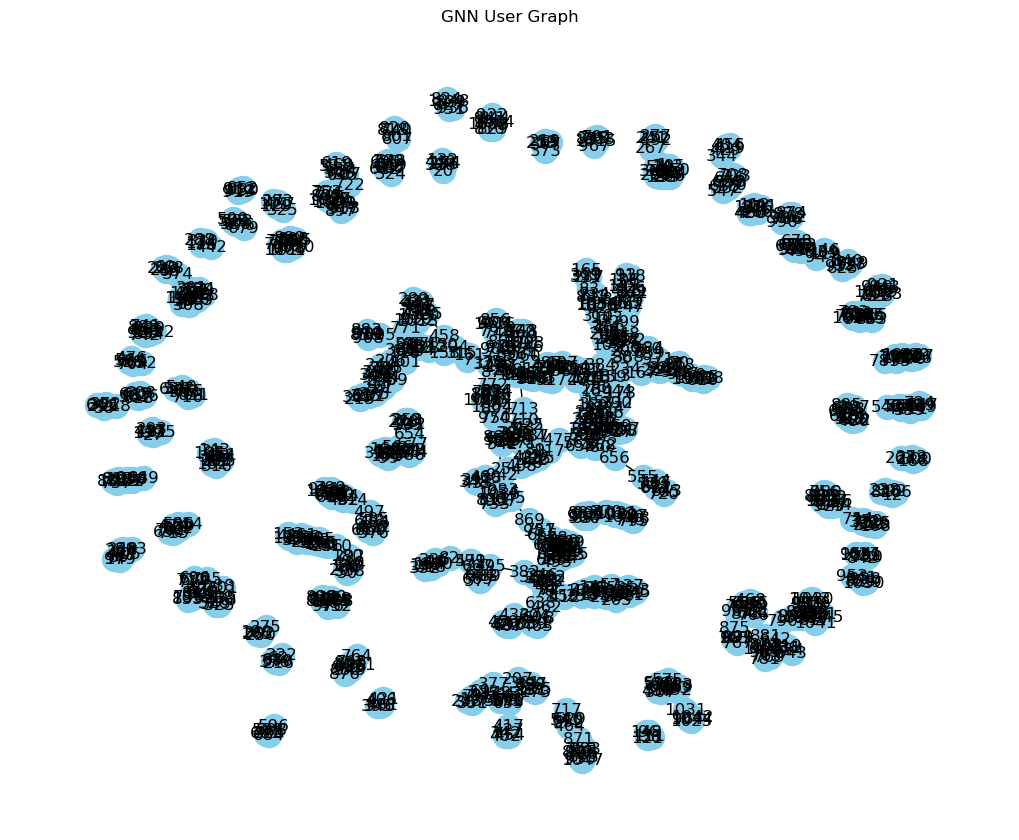

In [62]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True, node_size=300, node_color='skyblue')
plt.title("GNN User Graph")
plt.show()

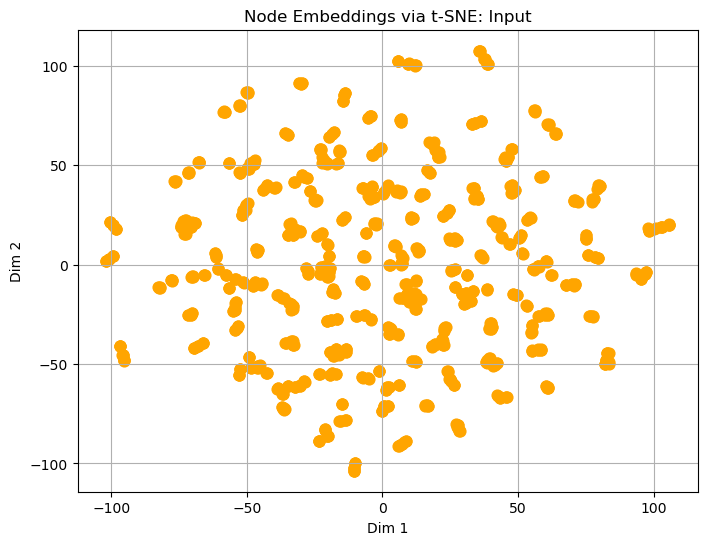

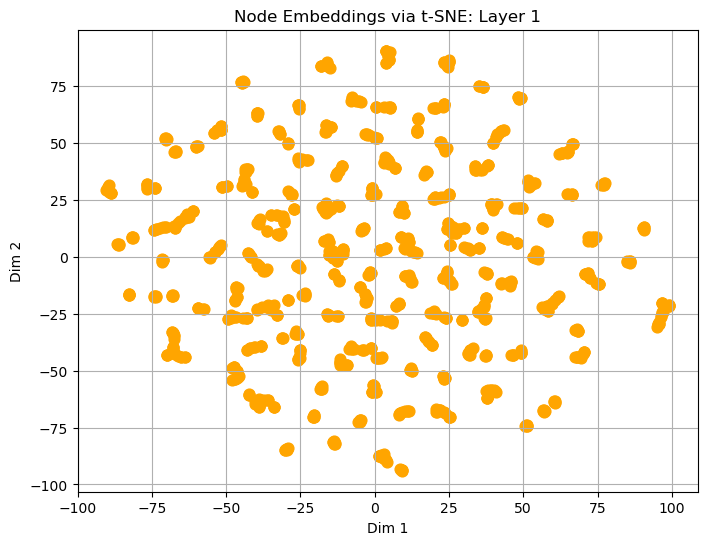

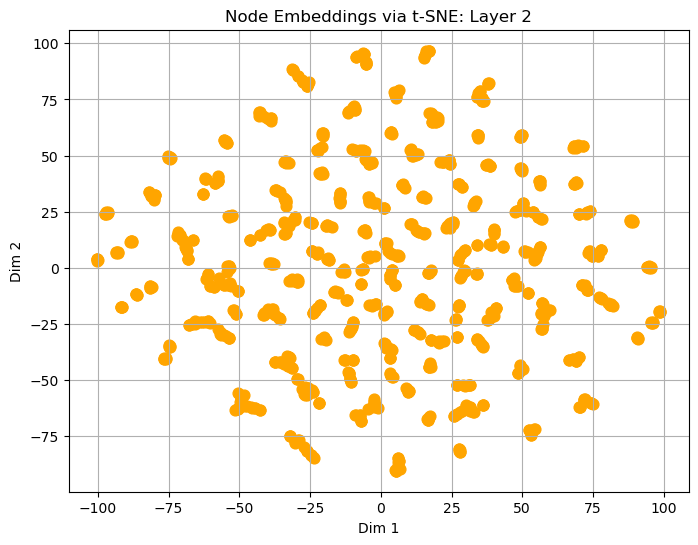

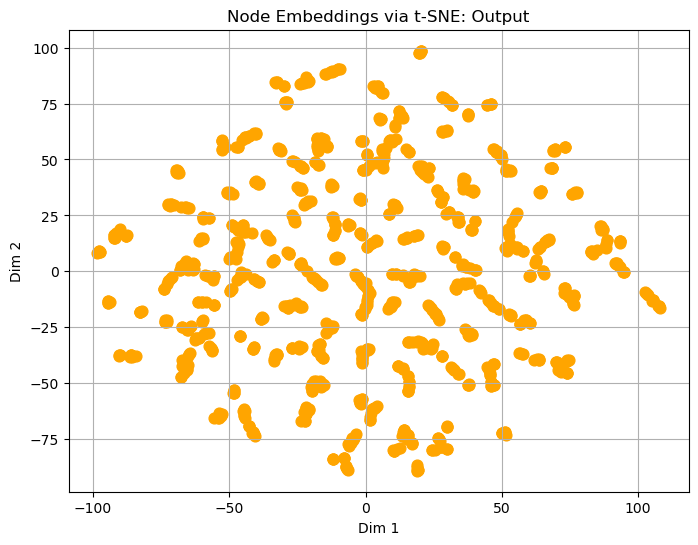

In [63]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_layer_embeddings(model, data, layer_names=['Input', 'Layer 1', 'Layer 2', 'Output']):
    model.eval()
    x = data.x
    edge_index = data.edge_index

    # Collect embeddings after each layer
    embeddings = [x.cpu().numpy()]  # Input features

    # Layer 1
    x1 = model.conv1(x, edge_index)
    x1_relu = F.relu(x1)
    embeddings.append(x1_relu.detach().cpu().numpy())

    # Layer 2
    x2 = model.conv2(x1_relu, edge_index)
    x2_relu = F.relu(x2)
    embeddings.append(x2_relu.detach().cpu().numpy())

    # Output layer (if you have a third layer, add here)
    out = model.out(x2_relu, edge_index)
    embeddings.append(out.detach().cpu().numpy())

    # Plot t-SNE for each layer
    for i, emb in enumerate(embeddings):
        tsne = TSNE(n_components=2, perplexity=5, random_state=42)
        emb_2d = tsne.fit_transform(emb)
        plt.figure(figsize=(8, 6))
        plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c='orange', s=60)
        plt.title(f"Node Embeddings via t-SNE: {layer_names[i]}")
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.grid(True)
        plt.show()

# Call the function
plot_layer_embeddings(model, data)

#### Define GCN model

In [39]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.out = GCNConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        return self.out(x, edge_index)


### Train the model

##### Create Train/Validation Masks

In [40]:
from sklearn.model_selection import train_test_split

indices = list(range(len(X)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_mask = torch.zeros(len(X), dtype=torch.bool)
val_mask = torch.zeros(len(X), dtype=torch.bool)
train_mask[train_idx] = True
val_mask[val_idx] = True

data.train_mask = train_mask
data.val_mask = val_mask

#### Train the Model

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(x.shape[1], 64, y.shape[1]).to(device)
data = data.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
criterion = nn.MSELoss()

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model.eval()
        val_out = model(data.x, data.edge_index)
        val_loss = criterion(val_out[data.val_mask], data.y[data.val_mask])
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")


Epoch 0 | Train Loss: 1.4454 | Val Loss: 1.3790
Epoch 10 | Train Loss: 0.9314 | Val Loss: 0.9259
Epoch 20 | Train Loss: 0.7775 | Val Loss: 0.7624
Epoch 30 | Train Loss: 0.6804 | Val Loss: 0.6638
Epoch 40 | Train Loss: 0.6200 | Val Loss: 0.6004
Epoch 50 | Train Loss: 0.5874 | Val Loss: 0.5577
Epoch 60 | Train Loss: 0.5450 | Val Loss: 0.5259
Epoch 70 | Train Loss: 0.5278 | Val Loss: 0.5007
Epoch 80 | Train Loss: 0.4965 | Val Loss: 0.4797
Epoch 90 | Train Loss: 0.4971 | Val Loss: 0.4627
Epoch 100 | Train Loss: 0.4751 | Val Loss: 0.4485
Epoch 110 | Train Loss: 0.4640 | Val Loss: 0.4353
Epoch 120 | Train Loss: 0.4496 | Val Loss: 0.4245
Epoch 130 | Train Loss: 0.4401 | Val Loss: 0.4155
Epoch 140 | Train Loss: 0.4329 | Val Loss: 0.4066
Epoch 150 | Train Loss: 0.4235 | Val Loss: 0.3988
Epoch 160 | Train Loss: 0.4058 | Val Loss: 0.3926
Epoch 170 | Train Loss: 0.4141 | Val Loss: 0.3857
Epoch 180 | Train Loss: 0.4135 | Val Loss: 0.3810
Epoch 190 | Train Loss: 0.3904 | Val Loss: 0.3756
Epoch 200 |

### Evaluate Model Performance

In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
preds = model(data.x, data.edge_index).detach().cpu().numpy()
true = data.y.detach().cpu().numpy()

# Inverse transform the predictions
preds = scaler_y.inverse_transform(preds)
true = scaler_y.inverse_transform(true)

print("MAE:", mean_absolute_error(true, preds))
print("RMSE:", mean_squared_error(true, preds, squared=False))
print("R² Score:", r2_score(true, preds))


MAE: 1.4889603
RMSE: 1.9796168
R² Score: 0.6974672869940765


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


#### Predict nutrient needs


In [43]:
model.eval()
predictions = model(data.x, data.edge_index).detach().cpu().numpy()
predicted_nutrition = pd.DataFrame(predictions, columns=target_cols)
print("\nPredicted Nutritional Needs:")
print(predicted_nutrition.head())


Predicted Nutritional Needs:
   Protein_Intake  Fat_Intake  Carbohydrate_Consumption  NutritionRisk  \
0       -1.278489    0.033096                 -0.255139       1.054165   
1       -0.441423    0.187168                 -0.518136      -0.667642   
2        0.006873   -0.160557                 -0.741061      -1.765878   
3        0.095448   -0.206063                 -0.201591      -0.616330   
4        0.362636   -0.199067                 -0.396422      -1.436803   

   DiabetesRisk  
0     -1.006446  
1     -1.101284  
2     -1.528128  
3     -0.603036  
4     -1.338796  


#### Visualize node embeddings

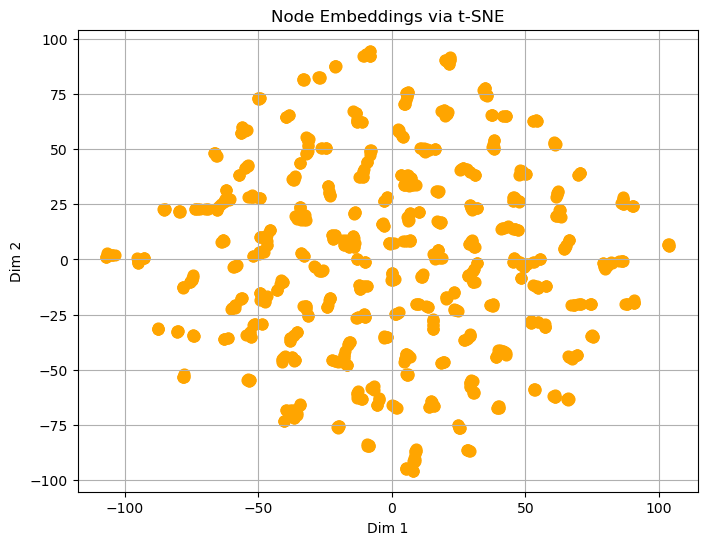

In [44]:
with torch.no_grad():
    embeddings = model.conv1(data.x, data.edge_index).cpu().numpy()

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c='orange', s=60)
plt.title("Node Embeddings via t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

#### Food recommendation function

In [45]:
def recommend_foods(protein_target, fat_target, carbs_target, top_n=5):
    food_df_clean = food_df.copy()
    food_df_clean[['Protein', 'Fat', 'Carbs']] = food_df_clean[['Protein', 'Fat', 'Carbs']].apply(pd.to_numeric, errors='coerce').fillna(0)

    food_df_clean['score'] = (
        abs(food_df_clean['Protein'] - protein_target) +
        abs(food_df_clean['Fat'] - fat_target) +
        abs(food_df_clean['Carbs'] - carbs_target)
    )

    return food_df_clean.sort_values('score').head(top_n)

 #### Recommend foods for the first user

In [46]:
first_user_pred = predicted_nutrition.iloc[0]
recommended = recommend_foods(
    protein_target=first_user_pred['Protein_Intake'],
    fat_target=first_user_pred['Fat_Intake'],
    carbs_target=first_user_pred['Carbohydrate_Consumption']
)

print("\nRecommended Foods for User 1:")
print(recommended[['Food', 'Measure', 'Grams', 'Calories', 'Protein', 'Fat', 'Carbs', 'Category']])



Recommended Foods for User 1:
                                         Food Measure Grams Calories  Protein  \
328                                 Club soda  12 oz.   346        0      0.0   
327  Carbonated drinks Artificially sweetened  12 oz.   346        0      0.0   
324                                       Gin   1 oz.    28       70      0.0   
130                                   Parsley    2 T.    50        2      0.0   
293                                 Ice cream  2 cups   300      250      0.0   

     Fat  Carbs                   Category  
328  0.0    0.0  Drinks,Alcohol, Beverages  
327  0.0    0.0  Drinks,Alcohol, Beverages  
324  0.0    0.0  Drinks,Alcohol, Beverages  
130  0.0    0.0             Vegetables F-P  
293  0.0    0.0           Desserts, sweets  


#### Meal portion splits (total = 1.0)

In [47]:
meal_ratios = {
    'breakfast': 0.25,
    'lunch': 0.30,
    'dinner': 0.30,
    'snack': 0.15
}

#### Build 7-day meal plan for a user

In [48]:
import random

# 12. Generate a 7-day meal plan
def generate_meal_plan(user_pred, food_df, meals_per_day=['breakfast', 'lunch', 'dinner', 'snack']):
    plan = {}
    # Scale the total predicted intake to split across meals
    daily_targets = {
        'breakfast': 0.25,
        'lunch': 0.35,
        'dinner': 0.30,
        'snack': 0.10
    }

    for day in range(1, 8):
        day_plan = {}
        for meal in meals_per_day:
            ratio = daily_targets[meal]
            protein_target = user_pred['Protein_Intake'] * ratio
            fat_target = user_pred['Fat_Intake'] * ratio
            carbs_target = user_pred['Carbohydrate_Consumption'] * ratio

            recommended_meals = recommend_foods(protein_target, fat_target, carbs_target, top_n=5)

            # Randomly pick one meal from the top recommendations
            chosen = recommended_meals.sample(1).iloc[0]
            day_plan[meal] = {
                'Food': chosen['Food'],
                'Calories': chosen['Calories'],
                'Grams': chosen['Grams'],
                'Protein': chosen['Protein'],
                'Fat': chosen['Fat'],
                'Carbs': chosen['Carbs'],
                'Category': chosen.get('Category', 'Unknown')
            }
        plan[f'Day {day}'] = day_plan
    return plan

# Generate meal plan for first user
meal_plan = generate_meal_plan(first_user_pred, food_df)

# Pretty-print the plan
from pprint import pprint
print("\n7-Day Meal Plan for User 1:")
pprint(meal_plan)



7-Day Meal Plan for User 1:
{'Day 1': {'breakfast': {'Calories': '70',
                         'Carbs': 0.0,
                         'Category': 'Drinks,Alcohol, Beverages',
                         'Fat': 0.0,
                         'Food': 'Gin',
                         'Grams': '28',
                         'Protein': 0.0},
           'dinner': {'Calories': '2',
                      'Carbs': 0.0,
                      'Category': 'Vegetables F-P',
                      'Fat': 0.0,
                      'Food': 'Parsley',
                      'Grams': '50',
                      'Protein': 0.0},
           'lunch': {'Calories': '0',
                     'Carbs': 0.0,
                     'Category': 'Drinks,Alcohol, Beverages',
                     'Fat': 0.0,
                     'Food': 'Club soda',
                     'Grams': '346',
                     'Protein': 0.0},
           'snack': {'Calories': '2',
                     'Carbs': 0.0,
                     'Catego

In [ ]:
y_true = y  # shape: (num_samples, num_targets)
y_pred = predicted_nutrition.values  # shape: (num_samples, num_targets)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

#### Generate plan for first user